In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
sys.path.append('..')

import os

from tqdm.autonotebook import tqdm
tqdm.pandas()

%matplotlib inline  
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import json

/var/folders/73/1_fd1jr14477j2fv2b70mpx00000gn/T/ipykernel_25650/684597363.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
from kst.data_sets.TextDocument import TextDocument
from kst.data_sets.TextCorpus import TextCorpus

In [4]:
from gensim.parsing.preprocessing import (
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    remove_stopwords,
    strip_short,
    strip_numeric,
    stem_text
)

In [5]:
GENSIM_CUSTOM_TEKENIZER = [
            lambda x: x.lower(),
            strip_tags,
            strip_punctuation,
            strip_multiple_whitespaces,
            remove_stopwords,
            strip_numeric,
            lambda x: strip_short(x, minsize=2),
        ]

# Training data

In [6]:
tc = TextCorpus(corpus_description='acl imdb train corpus', gensim_custom_tokenizer=GENSIM_CUSTOM_TEKENIZER)

In [7]:
docs_path = "/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/train/neg"
for file in tqdm(os.listdir(docs_path)):
    if file.endswith("txt"):
        tc.add_document(TextDocument(os.path.join(docs_path,file), 0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12501/12501 [00:15<00:00, 821.32it/s]


In [8]:
docs_path = "/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/train/pos"
for file in tqdm(os.listdir(docs_path)):
    if file.endswith("txt"):
        tc.add_document(TextDocument(os.path.join(docs_path,file), 1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:15<00:00, 800.23it/s]


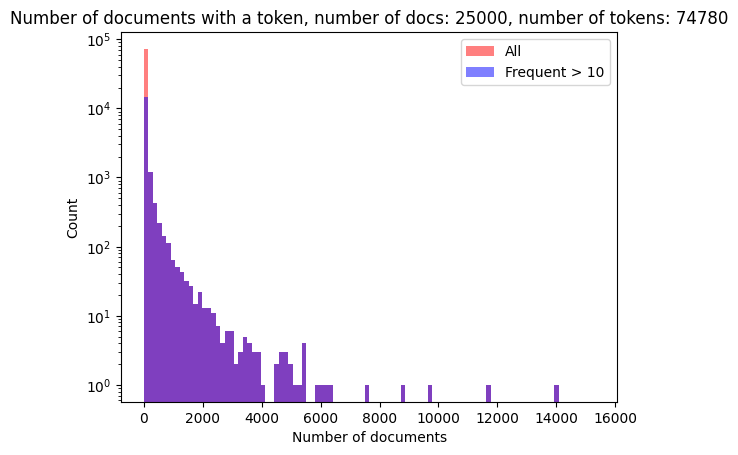

In [9]:
min_docks = 10
bin_size = int(max(list(tc.token_doc_count.values()))/100)
my_bins = range(0,max(list(tc.token_doc_count.values())),bin_size)
plt.hist([i for i in list(tc.token_doc_count.values()) if (i > 0)], bins = my_bins, color = 'red', alpha = 0.5, label = 'All')
plt.hist([i for i in list(tc.token_doc_count.values()) if (i > min_docks)], bins = my_bins, color = 'blue', alpha = 0.5, label = f'Frequent > {min_docks}')
plt.yscale("log")
plt.title(f"""Number of documents with a token, number of docs: {tc.docs_count}, number of tokens: {tc.tokens_count}""")
plt.xlabel("Number of documents")
plt.ylabel("Count")
plt.legend(loc="upper right")

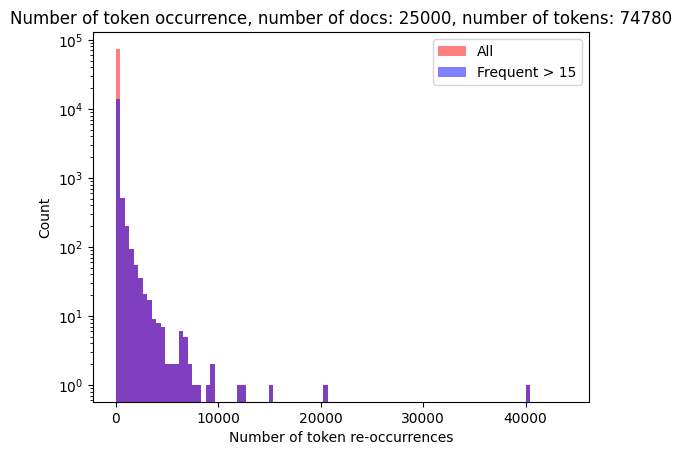

In [10]:
min_count = 15
bin_size = int(max(list(tc.token_absolute_count.values()))/100)
my_bins = range(0,max(list(tc.token_absolute_count.values())),bin_size)
plt.hist([i for i in list(tc.token_absolute_count.values()) if (i > 0)], bins = my_bins, color = 'red', alpha = 0.5, label = 'All')
plt.hist([i for i in list(tc.token_absolute_count.values()) if (i > min_count)], bins = my_bins, color = 'blue', alpha = 0.5, label = f'Frequent > {min_count}')
plt.yscale("log")
plt.title(f"""Number of token occurrence, number of docs: {tc.docs_count}, number of tokens: {tc.tokens_count}""")
plt.xlabel("Number of token re-occurrences")
plt.ylabel("Count")
plt.legend(loc="upper right")

In [11]:
tc.tokens_count

74780

In [12]:
len(tc.get_frequent_tokens(min_count,min_docks))

14987

In [13]:
len(tc.get_rare_tokens(min_count,min_docks))

57435

In [14]:
len(tc.get_frequent_tokens(min_count,min_docks))+len(tc.get_rare_tokens(min_count,min_docks))

72422

In [15]:
tc.get_rare_tokens(min_count,min_docks)[:10]

['creditable',
 'blasters',
 'dumpster',
 'profusely',
 'dodds',
 'lonnie',
 'kirkendalls',
 'roadtrip',
 'despirately',
 'blurted']

In [16]:
tc.get_frequent_tokens(5500, 10000)

['film', 'movie', 'like']

In [17]:
too_rare = tc.get_rare_tokens(min_count,min_docks)
too_frequent = tc.get_frequent_tokens(5500, 10000)

tokens_to_exclude =  too_rare + too_frequent

In [18]:
corpus, token2index, index2token = tc.get_corpus(tokens_to_exclude)

Getting corpus: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 24759.55it/s]


In [19]:
labels = tc.labels

In [20]:
corpus_df = pd.DataFrame.from_dict({'corpus':corpus, 'labels':labels})

In [21]:
corpus_df['token_indexes'] = corpus_df.corpus.map(lambda x: [token2index.get(i) for i in x if i in token2index.keys()])
corpus_df['n_tokens'] = corpus_df.token_indexes.map(lambda x: len(x))

In [22]:
corpus_df

,corpus,labels,token_indexes,n_tokens
0,"[working, best, shakespeare, sources, manages,...",0,"[17147, 1404, 13756, 14403, 9405, 14402, 16959...",18
1,"[tremors, original, started, enjoyable, watch,...",0,"[15936, 10818, 14684, 5146, 16838, 11915, 1593...",65
2,"[ouch, bit, painful, sit, cute, amusing, premi...",0,"[10847, 1486, 10983, 14050, 3709, 503, 11799, ...",51
3,"[ve, seen, crappy, movies, life, worst, defina...",0,"[16511, 13594, 3489, 10143, 8968, 17168, 3960,...",137
4,"[follows, exploits, guys, gals, stolen, merced...",0,"[6031, 5494, 6881, 6327, 14793, 9732, 17139, 1...",347
...,...,...,...,...
24995,"[year, ago, finally, gave, american, televisio...",1,"[17254, 312, 5843, 6388, 479, 15427, 15580, 65...",62
24996,"[saw, elaborate, dvd, box, dreadful, red, quee...",1,"[13391, 4947, 4811, 1747, 4666, 12504, 12201, ...",58
24997,"[november, chance, reno, festival, lot, fun, t...",1,"[10561, 2419, 12704, 5776, 9182, 6265, 15399, ...",64
24998,"[great, loved, great, editing, use, soundtrack...",1,"[6727, 9200, 6727, 4898, 16430, 14398, 2188, 1...",47


# Test data

In [23]:
tc_test = TextCorpus(corpus_description='ac imdb test corpus', gensim_custom_tokenizer=GENSIM_CUSTOM_TEKENIZER)

In [24]:
docs_path = "/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/test/neg"
for file in tqdm(os.listdir(docs_path)):
    if file.endswith("txt"):
        tc_test.add_document(TextDocument(os.path.join(docs_path,file), 0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:15<00:00, 828.97it/s]


In [25]:
docs_path = "/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/test/pos"
for file in tqdm(os.listdir(docs_path)):
    if file.endswith("txt"):
        tc_test.add_document(TextDocument(os.path.join(docs_path,file), 1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:15<00:00, 821.67it/s]


In [26]:
corpus_test, token2index_test, index2token_test = tc_test.get_corpus(tokens_to_exclude)

Getting corpus: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 45926.32it/s]


In [27]:
labels_test = tc_test.labels

In [28]:
corpus_test_df = pd.DataFrame.from_dict({'corpus':corpus_test, 'labels':labels_test})

In [29]:
corpus_test_df['token_indexes'] = corpus_test_df.corpus.map(lambda x: [token2index.get(i) for i in x if i in token2index.keys()])
corpus_test_df['n_tokens'] = corpus_test_df.token_indexes.map(lambda x: len(x))

In [30]:
corpus_test_df

,corpus,labels,token_indexes,n_tokens
0,"[alan, emma, thompson, good, performances, sou...",0,"[364, 5043, 15573, 6612, 11258, 14406, 10408, ...",37
1,"[seen, care, think, going, paris, country, nat...",0,"[13594, 2196, 15558, 6593, 11066, 3423, 10303,...",41
2,"[los, angeles, alcoholic, lazy, hank, chinaski...",0,"[9173, 542, 377, 8825, 6978, 9581, 4295, 11263...",75
3,"[fumavano, le, lo, chiamavano, camposanto, fil...",0,"[8829, 9087, 5835, 8857, 9182, 4143, 16860, 48...",197
4,"[comment, good, films, utter, rubbish, aim, he...",0,"[2961, 6612, 5835, 16449, 13197, 332, 7192, 11...",75
...,...,...,...,...
24995,"[certainly, constructed, beginning, ending, da...",1,"[2387, 3228, 1315, 5101, 3809, 6010, 9001, 142...",139
24996,"[nice, comedy, grown, ups, masterfully, struct...",1,"[10426, 2935, 6810, 16408, 9553, 14901, 1, 982...",109
24997,"[jean, renoir, homage, paris, late, th, centur...",1,"[8310, 12705, 7367, 11066, 8782, 15512, 2381, ...",351
24998,"[movies, mean, movies, shootings, killings, li...",1,"[10143, 9641, 10143, 13879, 8581, 8968, 14812,...",41


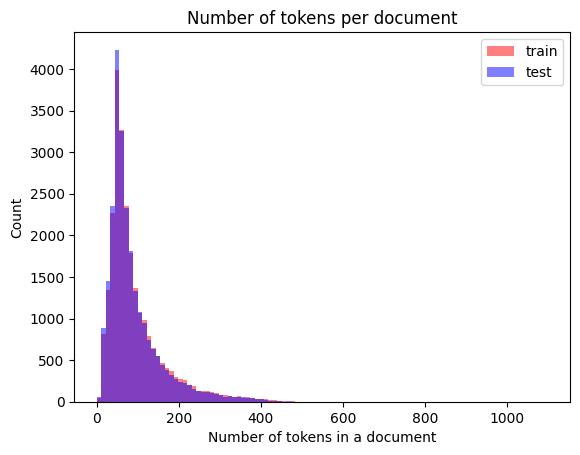

In [31]:
bin_size = int(max(list(corpus_df.n_tokens.values) + list(corpus_test_df.n_tokens.values))/100)
my_bins = range(0,max(list(corpus_df.n_tokens.values) + list(corpus_test_df.n_tokens.values)),bin_size)
plt.hist(corpus_df.n_tokens, bins = my_bins, color = 'red', alpha = 0.5, label='train')
plt.hist(corpus_test_df.n_tokens, bins = my_bins, color = 'blue', alpha = 0.5, label='test')
# plt.yscale("log")
plt.title(f"""Number of tokens per document""")
plt.xlabel("Number of tokens in a document")
plt.ylabel("Count")
plt.legend(loc="upper right")

# Store tokens

In [32]:
corpus_df.sample(frac = 1.0).to_pickle('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/corpus_train_df.pkl')

In [33]:
corpus_test_df.sample(frac = 1.0).to_pickle('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/corpus_test_df.pkl')

In [34]:
with open("/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/token2index.json", "w") as outfile:
    outfile.write(json.dumps(token2index))

In [35]:
with open("/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/index2token.json", "w") as outfile:
    outfile.write(json.dumps(index2token))